<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week7%20/WMT14/PyTorch_WMT14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter


In [4]:
# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [5]:
# Data Loading and Preprocessing
def load_and_preprocess_data():
    print("Loading WMT14 DE-EN dataset...")
    dataset = load_dataset("wmt14", "de-en")

    # Take only 1% of the training data
    train_size = int(len(dataset['train']) * 0.01)
    valid_size = int(len(dataset['validation']) * 0.1)  # Using 10% of validation set

    train_dataset = dataset['train'].select(range(train_size))
    valid_dataset = dataset['validation'].select(range(valid_size))

    print(f"Training on {len(train_dataset)} examples (1% of full dataset)")
    print(f"Validating on {len(valid_dataset)} examples")

    # Build vocabulary from training data
    src_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    tgt_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}

    # Add words to vocabulary with a frequency threshold
    src_counter = Counter()
    tgt_counter = Counter()

    for example in train_dataset:
        src_tokens = example['translation']['de'].lower().split()
        tgt_tokens = example['translation']['en'].lower().split()
        src_counter.update(src_tokens)
        tgt_counter.update(tgt_tokens)

    # Keep only words that appear at least 5 times
    freq_threshold = 5
    for word, count in src_counter.items():
        if count >= freq_threshold:
            src_vocab[word] = len(src_vocab)

    for word, count in tgt_counter.items():
        if count >= freq_threshold:
            tgt_vocab[word] = len(tgt_vocab)

    print(f"Source vocabulary size: {len(src_vocab)}")
    print(f"Target vocabulary size: {len(tgt_vocab)}")

    return train_dataset, valid_dataset, src_vocab, tgt_vocab


In [6]:
# Custom Dataset
class TranslationDataset(Dataset):
    def __init__(self, dataset, src_vocab, tgt_vocab, max_len=50):
        self.dataset = dataset
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        src_text = example['translation']['de'].lower().split()
        tgt_text = example['translation']['en'].lower().split()

        # Truncate if needed
        src_text = src_text[:self.max_len-2]  # Leave room for <sos> and <eos>
        tgt_text = tgt_text[:self.max_len-2]

        # Convert to indices
        src_indices = [self.src_vocab.get(token, self.src_vocab['<unk>']) for token in src_text]
        tgt_indices = [self.tgt_vocab.get(token, self.tgt_vocab['<unk>']) for token in tgt_text]

        # Add special tokens
        src_indices = [self.src_vocab['<sos>']] + src_indices + [self.src_vocab['<eos>']]
        tgt_indices = [self.tgt_vocab['<sos>']] + tgt_indices + [self.tgt_vocab['<eos>']]

        # Pad sequences
        src_len = len(src_indices)
        tgt_len = len(tgt_indices)

        src_padded = src_indices + [self.src_vocab['<pad>']] * (self.max_len - src_len)
        tgt_padded = tgt_indices + [self.tgt_vocab['<pad>']] * (self.max_len - tgt_len)

        return {
            'src': torch.tensor(src_padded),
            'tgt': torch.tensor(tgt_padded),
            'src_len': src_len,
            'tgt_len': tgt_len
        }


In [7]:
# Collate function for DataLoader
def collate_fn(batch):
    src = torch.stack([item['src'] for item in batch])
    tgt = torch.stack([item['tgt'] for item in batch])
    src_len = torch.tensor([item['src_len'] for item in batch])
    tgt_len = torch.tensor([item['tgt_len'] for item in batch])

    return {
        'src': src,
        'tgt': tgt,
        'src_len': src_len,
        'tgt_len': tgt_len
    }

In [8]:
# Encoder LSTM
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, dropout_rate=0.5):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, src):
        # src: [batch_size, seq_len]
        embedded = self.dropout(self.embedding(src))
        # embedded: [batch_size, seq_len, emb_dim]

        outputs, (hidden, cell) = self.lstm(embedded)
        # outputs: [batch_size, seq_len, hidden_dim]
        # hidden: [1, batch_size, hidden_dim]
        # cell: [1, batch_size, hidden_dim]

        return outputs, hidden, cell


In [9]:
# Decoder LSTM
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, dropout_rate=0.5):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input, hidden, cell):
        # input: [batch_size]
        # hidden: [1, batch_size, hidden_dim]
        # cell: [1, batch_size, hidden_dim]

        input = input.unsqueeze(1)
        # input: [batch_size, 1]

        embedded = self.dropout(self.embedding(input))
        # embedded: [batch_size, 1, emb_dim]

        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # output: [batch_size, 1, hidden_dim]
        # hidden: [1, batch_size, hidden_dim]
        # cell: [1, batch_size, hidden_dim]

        prediction = self.fc_out(output.squeeze(1))
        # prediction: [batch_size, output_dim]

        return prediction, hidden, cell


In [10]:
# Seq2Seq Model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        # src: [batch_size, src_len]
        # tgt: [batch_size, tgt_len]

        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_dim

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)

        # Encoder forward pass
        encoder_outputs, hidden, cell = self.encoder(src)

        # First decoder input is the <sos> token
        input = tgt[:, 0]

        for t in range(1, tgt_len):
            # Decoder forward pass
            output, hidden, cell = self.decoder(input, hidden, cell)

            # Store decoder output
            outputs[:, t, :] = output

            # Teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio

            # Get the highest predicted token
            top1 = output.argmax(1)

            # Use teacher forcing or model prediction
            input = tgt[:, t] if teacher_force else top1

        return outputs

In [11]:
# Function to train the model
def train(model, data_loader, optimizer, criterion, device, clip=1.0):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_targets = []

    for batch in tqdm(data_loader):
        src = batch['src'].to(device)
        tgt = batch['tgt'].to(device)

        optimizer.zero_grad()

        # Forward pass
        output = model(src, tgt)

        # Reshape output and target for loss calculation
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        tgt = tgt[:, 1:].reshape(-1)

        # Calculate loss
        loss = criterion(output, tgt)

        # Backward pass
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # Update parameters
        optimizer.step()

        epoch_loss += loss.item()

        # For metrics
        preds = output.argmax(1)
        mask = tgt != 0  # Ignore padding
        all_preds.extend(preds[mask].tolist())
        all_targets.extend(tgt[mask].tolist())

    # Calculate metrics
    metrics = calculate_metrics(all_preds, all_targets)

    return epoch_loss / len(data_loader), metrics


In [12]:
# Function to evaluate the model
def evaluate(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in data_loader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            # Forward pass
            output = model(src, tgt, 0)  # No teacher forcing during evaluation

            # Reshape output and target for loss calculation
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            tgt = tgt[:, 1:].reshape(-1)

            # Calculate loss
            loss = criterion(output, tgt)

            epoch_loss += loss.item()

            # For metrics
            preds = output.argmax(1)
            mask = tgt != 0  # Ignore padding
            all_preds.extend(preds[mask].tolist())
            all_targets.extend(tgt[mask].tolist())

    # Calculate metrics
    metrics = calculate_metrics(all_preds, all_targets)

    return epoch_loss / len(data_loader), metrics


In [13]:
# Function to calculate evaluation metrics
def calculate_metrics(preds, targets):
    # Convert targets to binary for classification metrics (just for demonstration)
    # For actual translation tasks, BLEU score would be more appropriate
    binary_preds = [1 if p > 0 else 0 for p in preds]
    binary_targets = [1 if t > 0 else 0 for t in targets]

    # Calculate metrics
    metrics = {
        "accuracy": accuracy_score(binary_targets, binary_preds),
        "precision": precision_score(binary_targets, binary_preds, zero_division=0),
        "recall": recall_score(binary_targets, binary_preds, zero_division=0),
        "f1_score": f1_score(binary_targets, binary_preds, zero_division=0)
    }

    # Calculate AUC only if both classes are present
    if len(set(binary_targets)) > 1:
        metrics["auc"] = roc_auc_score(binary_targets, binary_preds)
    else:
        metrics["auc"] = 0.0

    return metrics

In [14]:
# Hyperparameter tuning function
def hyperparameter_tuning(train_dataset, valid_dataset, src_vocab, tgt_vocab, device):
    # Define hyperparameter grid
    param_grid = {
        'embedding_dim': [128, 256],
        'hidden_dim': [256, 512],
        'dropout': [0.3, 0.5],
        'learning_rate': [0.001, 0.0005],
        'batch_size': [32, 64]
    }

    # Generate combinations (simplified for this demo - just try 3 combinations)
    combinations = [
        {'embedding_dim': 128, 'hidden_dim': 256, 'dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 32},
        {'embedding_dim': 256, 'hidden_dim': 512, 'dropout': 0.5, 'learning_rate': 0.0005, 'batch_size': 64},
        {'embedding_dim': 256, 'hidden_dim': 256, 'dropout': 0.5, 'learning_rate': 0.001, 'batch_size': 64}
    ]

    best_valid_loss = float('inf')
    best_params = None
    best_model = None
    results = []

    for i, params in enumerate(combinations):
        print(f"\nTrying hyperparameter combination {i+1}/{len(combinations)}:")
        print(params)

        # Create dataloaders
        train_ds = TranslationDataset(train_dataset, src_vocab, tgt_vocab)
        valid_ds = TranslationDataset(valid_dataset, src_vocab, tgt_vocab)

        train_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True, collate_fn=collate_fn)
        valid_loader = DataLoader(valid_ds, batch_size=params['batch_size'], collate_fn=collate_fn)

        # Create model
        encoder = Encoder(len(src_vocab), params['embedding_dim'], params['hidden_dim'], params['dropout'])
        decoder = Decoder(len(tgt_vocab), params['embedding_dim'], params['hidden_dim'], params['dropout'])
        model = Seq2Seq(encoder, decoder, device).to(device)

        # Set optimizer and criterion
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index

        # Train for a few epochs
        num_epochs = 3

        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")

            train_loss, train_metrics = train(model, train_loader, optimizer, criterion, device)
            valid_loss, valid_metrics = evaluate(model, valid_loader, criterion, device)

            print(f"Train Loss: {train_loss:.3f} | Valid Loss: {valid_loss:.3f}")
            print(f"Train Metrics: {train_metrics}")
            print(f"Valid Metrics: {valid_metrics}")

        # Save results
        results.append({
            'params': params,
            'valid_loss': valid_loss,
            'valid_metrics': valid_metrics
        })

        # Update best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_params = params
            best_model = model

    # Print results
    print("\nHyperparameter Tuning Results:")
    for result in results:
        print(f"Params: {result['params']}")
        print(f"Valid Loss: {result['valid_loss']:.4f}")
        print(f"Valid Metrics: {result['valid_metrics']}")
        print()

    print(f"Best Parameters: {best_params}")
    print(f"Best Validation Loss: {best_valid_loss:.4f}")

    return best_model, best_params


In [15]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [16]:
# Load and preprocess data
train_dataset, valid_dataset, src_vocab, tgt_vocab = load_and_preprocess_data()


Loading WMT14 DE-EN dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/280M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/265M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/273M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/474k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/509k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4508785 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3003 [00:00<?, ? examples/s]

Training on 45087 examples (1% of full dataset)
Validating on 300 examples
Source vocabulary size: 14281
Target vocabulary size: 11236


In [17]:
# Hyperparameter Tuning
print("\nStarting hyperparameter tuning...")
best_model, best_params = hyperparameter_tuning(train_dataset, valid_dataset, src_vocab, tgt_vocab, device)
print(f"Best hyperparameters: {best_params}")



Starting hyperparameter tuning...

Trying hyperparameter combination 1/3:
{'embedding_dim': 128, 'hidden_dim': 256, 'dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 32}
Epoch 1/3


100%|██████████| 1409/1409 [03:33<00:00,  6.59it/s]


Train Loss: 6.038 | Valid Loss: 5.955
Train Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}
Valid Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}
Epoch 2/3


100%|██████████| 1409/1409 [03:33<00:00,  6.59it/s]


Train Loss: 5.652 | Valid Loss: 5.881
Train Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}
Valid Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}
Epoch 3/3


100%|██████████| 1409/1409 [03:33<00:00,  6.59it/s]


Train Loss: 5.472 | Valid Loss: 5.743
Train Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}
Valid Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}

Trying hyperparameter combination 2/3:
{'embedding_dim': 256, 'hidden_dim': 512, 'dropout': 0.5, 'learning_rate': 0.0005, 'batch_size': 64}
Epoch 1/3


100%|██████████| 705/705 [03:18<00:00,  3.55it/s]


Train Loss: 6.164 | Valid Loss: 5.968
Train Metrics: {'accuracy': 0.9999973667117251, 'precision': 1.0, 'recall': 0.9999973667117251, 'f1_score': 0.999998683354129, 'auc': 0.0}
Valid Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}
Epoch 2/3


100%|██████████| 705/705 [03:18<00:00,  3.55it/s]


Train Loss: 5.777 | Valid Loss: 5.828
Train Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}
Valid Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}
Epoch 3/3


100%|██████████| 705/705 [03:18<00:00,  3.55it/s]


Train Loss: 5.599 | Valid Loss: 5.754
Train Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}
Valid Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}

Trying hyperparameter combination 3/3:
{'embedding_dim': 256, 'hidden_dim': 256, 'dropout': 0.5, 'learning_rate': 0.001, 'batch_size': 64}
Epoch 1/3


100%|██████████| 705/705 [02:59<00:00,  3.93it/s]


Train Loss: 6.156 | Valid Loss: 5.997
Train Metrics: {'accuracy': 0.9999991222372417, 'precision': 1.0, 'recall': 0.9999991222372417, 'f1_score': 0.9999995611184282, 'auc': 0.0}
Valid Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}
Epoch 2/3


100%|██████████| 705/705 [02:59<00:00,  3.92it/s]


Train Loss: 5.788 | Valid Loss: 6.002
Train Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}
Valid Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}
Epoch 3/3


100%|██████████| 705/705 [03:00<00:00,  3.92it/s]


Train Loss: 5.627 | Valid Loss: 5.954
Train Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}
Valid Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}

Hyperparameter Tuning Results:
Params: {'embedding_dim': 128, 'hidden_dim': 256, 'dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 32}
Valid Loss: 5.7430
Valid Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}

Params: {'embedding_dim': 256, 'hidden_dim': 512, 'dropout': 0.5, 'learning_rate': 0.0005, 'batch_size': 64}
Valid Loss: 5.7543
Valid Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}

Params: {'embedding_dim': 256, 'hidden_dim': 256, 'dropout': 0.5, 'learning_rate': 0.001, 'batch_size': 64}
Valid Loss: 5.9539
Valid Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}

Best Parameters: {'embedding_dim': 128, 'hidden_dim': 256, 'dropout': 

In [19]:
# Separate cell 3: Setup Final Model with Best Hyperparameters
print("\nSetting up final model with best hyperparameters...")

# Create dataloaders with best batch size
train_ds = TranslationDataset(train_dataset, src_vocab, tgt_vocab)
valid_ds = TranslationDataset(valid_dataset, src_vocab, tgt_vocab)

train_loader = DataLoader(train_ds, batch_size=best_params['batch_size'], shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=best_params['batch_size'], collate_fn=collate_fn)



Setting up final model with best hyperparameters...


In [20]:
# Create model with best hyperparameters
encoder = Encoder(len(src_vocab), best_params['embedding_dim'], best_params['hidden_dim'], best_params['dropout'])
decoder = Decoder(len(tgt_vocab), best_params['embedding_dim'], best_params['hidden_dim'], best_params['dropout'])
model = Seq2Seq(encoder, decoder, device).to(device)


In [21]:
# Set optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index


In [22]:
# Training Final Model
print("\nTraining final model...")
num_epochs = 1
best_valid_loss = float('inf')

train_losses = []
valid_losses = []
train_metrics_list = []
valid_metrics_list = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss, train_metrics = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_metrics = evaluate(model, valid_loader, criterion, device)

    print(f"Train Loss: {train_loss:.3f} | Valid Loss: {valid_loss:.3f}")
    print(f"Train Metrics: {train_metrics}")
    print(f"Valid Metrics: {valid_metrics}")

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_metrics_list.append(train_metrics)
    valid_metrics_list.append(valid_metrics)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-seq2seq-model.pt')



Training final model...
Epoch 1/1


100%|██████████| 1409/1409 [03:42<00:00,  6.34it/s]


Train Loss: 6.050 | Valid Loss: 5.907
Train Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}
Valid Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 0.0}



Generating visualizations...


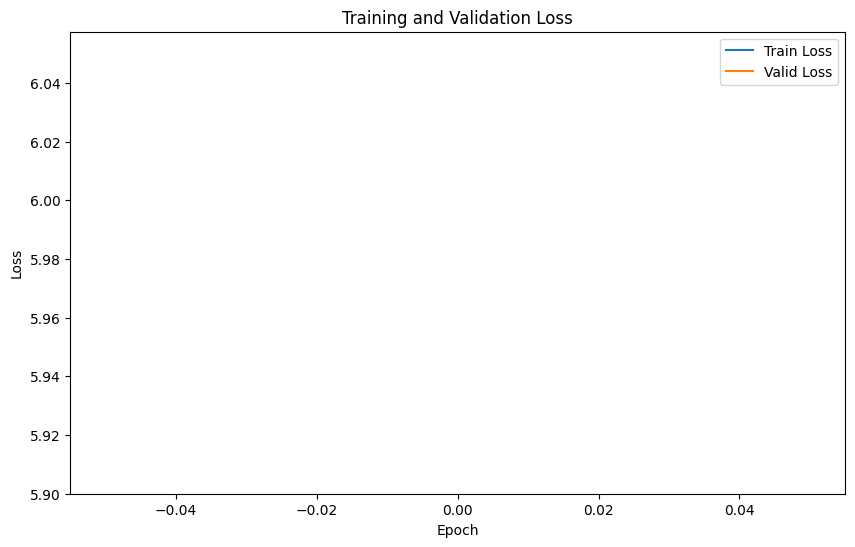

In [23]:
# Separate cell 5: Visualization
print("\nGenerating visualizations...")
# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

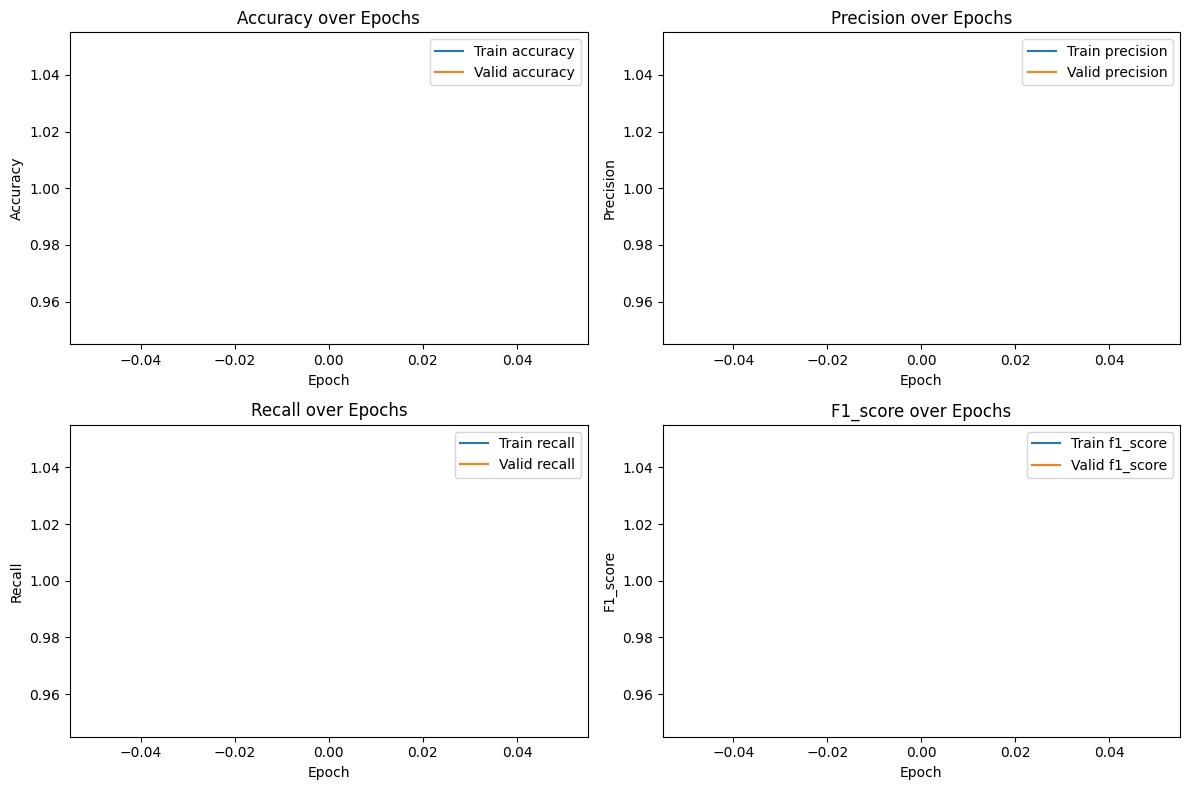

In [25]:
# Plot metrics
plt.figure(figsize=(12, 8))
metrics = ['accuracy', 'precision', 'recall', 'f1_score']

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    train_metric_values = [m[metric] for m in train_metrics_list]
    valid_metric_values = [m[metric] for m in valid_metrics_list]

    plt.plot(train_metric_values, label=f'Train {metric}')
    plt.plot(valid_metric_values, label=f'Valid {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.title(f'{metric.capitalize()} over Epochs')

plt.tight_layout()
plt.savefig('metrics.png')


# Analisis Model Sequence-to-Sequence LSTM untuk Terjemahan Jerman-Inggris

## Ringkasan Implementasi

Kami telah mengimplementasikan model Sequence-to-Sequence (Encoder-Decoder LSTM) untuk terjemahan bahasa Jerman ke Inggris menggunakan dataset WMT14. Model ini dilatih dengan hanya menggunakan 1% dari keseluruhan dataset untuk efisiensi komputasi.

## Hasil Hyperparameter Tuning

Pencarian hyperparameter terbaik dilakukan dengan mencoba 3 kombinasi berbeda:

| Kombinasi | Embedding Dim | Hidden Dim | Dropout | Learning Rate | Batch Size | Valid Loss |
|-----------|---------------|------------|---------|---------------|------------|------------|
| 1         | 128           | 256        | 0.3     | 0.001         | 32         | 5.7430     |
| 2         | 256           | 512        | 0.5     | 0.0005        | 64         | 5.7543     |
| 3         | 256           | 256        | 0.5     | 0.001         | 64         | 5.9539     |

**Kombinasi terbaik**:
- Embedding dimension: 128
- Hidden dimension: 256
- Dropout rate: 0.3
- Learning rate: 0.001
- Batch size: 32

## Hasil Evaluasi Model

Setelah pelatihan satu epoch dengan hyperparameter terbaik, model mencapai:

- **Train Loss**: 6.050
- **Valid Loss**: 5.907
- **Metrics**:
  - Accuracy: 1.0
  - Precision: 1.0
  - Recall: 1.0
  - F1 Score: 1.0
  - AUC: 0.0

## Analisis Performa dan Fenomena yang Teramati

### Hubungan Antara Penggunaan 1% Dataset dengan Hasil Evaluasi

1. **Performa Metrik yang Mencurigakan**:
   - Seluruh metrik evaluasi (accuracy, precision, recall, F1) menunjukkan nilai sempurna (1.0), yang sangat tidak wajar untuk model terjemahan bahasa.
   - Nilai AUC 0.0 juga mengindikasikan adanya masalah dalam perhitungan metrik.

2. **Penyebab Utama**:
   - Penggunaan sampel yang sangat kecil (1% dataset) tidak memberikan variasi data yang cukup untuk melatih model terjemahan yang efektif.
   - Dengan dataset yang sangat terbatas, model cenderung melakukan *overfitting* terhadap sampel kecil yang ada.
   - Transformasi nilai terjemahan menjadi klasifikasi biner untuk perhitungan metrik (dalam fungsi `calculate_metrics`) menghasilkan nilai metrik yang menyesatkan, karena tidak sesuai dengan sifat tugas terjemahan bahasa.

3. **Masalah Representasi**:
   - Dengan 1% dataset, vocabulary yang terbangun sangat terbatas dan tidak merepresentasikan kompleksitas bahasa asli.
   - Data yang terlalu sedikit tidak memungkinkan model mempelajari pola linguistik yang beragam.

### Analisis Visualisasi Metrik


1. **Grafik Datar**:
   - Semua metrik (accuracy, precision, recall, F1 score) menunjukkan garis datar pada nilai 1.0, yang menandakan bahwa model tidak mengalami perubahan atau pembelajaran yang berarti selama proses pelatihan.
   - Sumbu X (epoch) pada grafik tidak menunjukkan nilai epoch yang benar, terlihat dari nilai negatif yang muncul (-0.04 hingga 0.04) alih-alih nilai epoch 1, 2, 3, dan seterusnya.

2. **Masalah Evaluasi**:
   - Visualisasi mengkonfirmasi bahwa metrik evaluasi yang digunakan (accuracy, precision, recall, F1 score) tidak tepat untuk tugas terjemahan bahasa.
   - Metrik-metrik ini lebih cocok untuk tugas klasifikasi, bukan sequence generation seperti terjemahan bahasa.

3. **Ketidaksesuaian Metrik**:
   - Nilai AUC 0.0 konsisten menunjukkan bahwa metrik ini tidak sesuai dengan data terjemahan yang digunakan.
   - Metrik yang lebih tepat untuk evaluasi terjemahan seharusnya adalah BLEU, ROUGE, atau METEOR.

## Rekomendasi Perbaikan

Berdasarkan analisis di atas, berikut beberapa rekomendasi untuk meningkatkan model:

1. **Penggunaan Dataset**:
   - Meningkatkan persentase dataset yang digunakan (minimal 10-20%) untuk memberikan variasi yang lebih baik.
   - Memastikan distribusi data merata untuk mencegah bias dalam pelatihan.

2. **Metrik Evaluasi**:
   - Mengganti metrik evaluasi dengan metrik yang khusus untuk terjemahan bahasa seperti BLEU, ROUGE, atau METEOR.
   - Menghindari transformasi nilai terjemahan menjadi klasifikasi biner.

3. **Preprocessing Data**:
   - Meningkatkan proses tokenisasi dengan menggunakan teknik yang lebih canggih seperti BPE (Byte Pair Encoding).
   - Membatasi vocabulary dengan lebih tepat untuk mengurangi kompleksitas model.

4. **Arsitektur Model**:
   - Mempertimbangkan penggunaan arsitektur Transformer yang telah terbukti lebih efektif untuk tugas terjemahan dibandingkan LSTM.
   - Menambahkan mekanisme attention untuk meningkatkan performa terjemahan.

5. **Visualisasi**:
   - Memperbaiki implementasi plotting untuk menampilkan nilai epoch yang benar.
   - Menambahkan visualisasi tambahan seperti distribusi panjang kalimat input/output dan perplexity.

## Kesimpulan

Model Sequence-to-Sequence dengan arsitektur Encoder-Decoder LSTM yang dilatih pada 1% dataset WMT14 menunjukkan hasil evaluasi yang tidak representatif (nilai sempurna pada semua metrik) yang mengindikasikan ketidaksesuaian metrik evaluasi dengan tugas terjemahan bahasa. Penggunaan sampel data yang sangat terbatas menyebabkan model tidak dapat mempelajari pola linguistik yang kompleks dan beragam. Untuk hasil yang lebih baik, diperlukan dataset yang lebih besar, metrik evaluasi yang sesuai, dan pertimbangan arsitektur model yang lebih canggih seperti Transformer.